In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt

print(sns.__version__)
# Save a palette to a variable:
palette = sns.color_palette("bright")

sns.set_palette(palette)

0.12.2


# corona

In [ ]:
CORONA_PATH = "/m/cs/work/luongn1/digirhythm/data/processed/corona/similarity_matrix/"
FEATURES = ["heart_rate_variability_avg","stepsx1000:total","steps:night:norm","steps:morning:norm","steps:afternoon:norm","steps:evening:norm","tst","midsleep"]
FEATURES_7DS = ["heart_rate_variability_avg:mean",'steps:night:7ds:sum:norm','steps:morning:7ds:sum:norm', 'steps:afternoon:7ds:sum:norm',
       'steps:evening:7ds:sum:norm', 'stepsx1000:total',"tst:mean","midsleep:mean"]
uid = "1392475402"
freq = "7ds"

# Take a sample
behavior_vector = pd.read_csv(f"/m/cs/work/luongn1/digirhythm/data/processed/corona/vector_corona_{freq}.csv")
sample = pd.read_csv(CORONA_PATH + f"{freq}/similarity_{uid}.csv", index_col=0)
similarity_baseline_si = pd.read_csv(
    CORONA_PATH + f"si/similarity_baseline_{freq}.csv", index_col=0
)
similarity_baseline_cluster = pd.read_csv(
    CORONA_PATH + f"cluster/similarity_baseline_{freq}.csv", index_col=0
)
similarity_baseline_average = pd.read_csv(
    CORONA_PATH + f"average/similarity_baseline_{freq}.csv", index_col=0
)
similarity_baseline_si.index = similarity_baseline_si.index.astype("str")
similarity_baseline_cluster.index = similarity_baseline_cluster.index.astype("str")
similarity_baseline_average.index = similarity_baseline_cluster.index.astype("str")
behavior_vector.subject_id = behavior_vector.subject_id.astype("str")

sample.shape

UID: 1392475402. Frequency: 4epochs


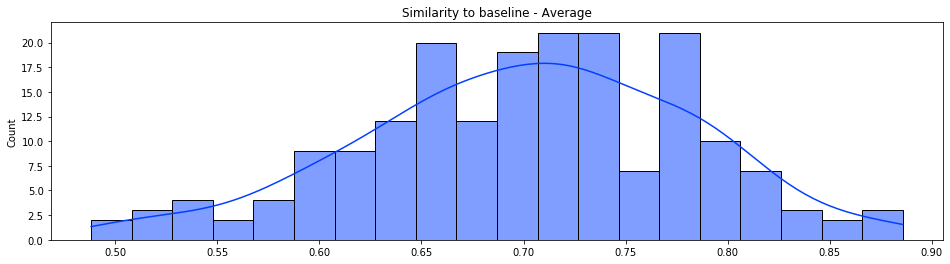

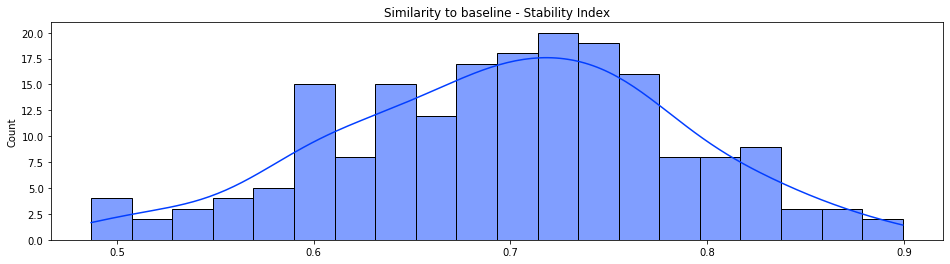

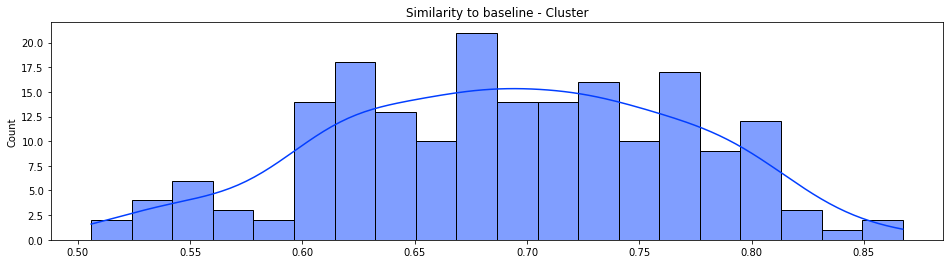

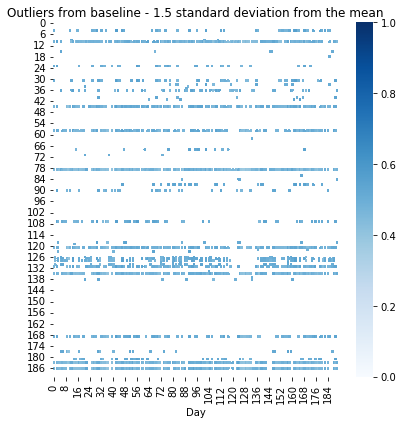

In [213]:
def recurrent_plot(df):
    # Viz
    sns.heatmap(df, cmap="Blues")

s_si = similarity_baseline_si.loc[uid].dropna()
s_cluster = similarity_baseline_cluster.loc[uid].dropna()
s_avg = similarity_baseline_average.loc[uid].dropna()

print(f'UID: {uid}. Frequency: {freq}')

# Line plot
plt.figure(figsize=(16, 4))
#sns.lineplot(x=s.index, y=s.values)
sns.histplot(s_avg.values, bins=20, kde=True)
plt.title('Similarity to baseline - Average')

# Line plot
plt.figure(figsize=(16, 4))
#sns.lineplot(x=s.index, y=s.values)
sns.histplot(s_si.values, bins=20, kde=True)
plt.title('Similarity to baseline - Stability Index')

# Line plot
plt.figure(figsize=(16, 4))
#sns.lineplot(x=s.index, y=s.values)
sns.histplot(s_cluster.values, bins=20, kde=True)
plt.title('Similarity to baseline - Cluster')

# Heatmap
plt.figure(figsize=(6, 6))
# Define the threshold
threshold = sample.mean() - 1.5*sample.std()

# Replace values above the threshold with NaN
sample_masked = sample.where(sample < threshold)
sns.heatmap(sample_masked, cmap="Blues", vmin=0, vmax=1)
xlabel = 'Day' if freq == '4epochs' else 'Week'
plt.xlabel(xlabel)
plt.title('Outliers from baseline - 1.5 standard deviation from the mean')

plt.tight_layout()
plt.show()

In [228]:
# Outliers - Days deviating the most from baseline
def outliers(similarity):
    # Calculate mean and standard deviation
    mean = similarity.mean()
    std_dev = similarity.std()

    # Calculate the lower threshold
    lower_threshold = mean - 1.5 * std_dev

    # Find indexes of outliers
    outliers = similarity[similarity <= lower_threshold].index

    return outliers

outlier_si = outliers(s_si)
outlier_avg = outliers(s_avg)
outlier_cluster = outliers(s_cluster)

print("Outlier SI: ", outlier_si)
print("Outlier AVG: ", outlier_avg)
print("Outlier Cluster: ", outlier_cluster)

# Pairwise agreements
si_avg_agreement = len(outlier_si.intersection(outlier_avg)) / len(outlier_si.union(outlier_avg))
avg_cluster_agreement = len(outlier_avg.intersection(outlier_cluster)) / len(outlier_avg.union(outlier_cluster))
cluster_si_agreement = len(outlier_cluster.intersection(outlier_si)) / len(outlier_cluster.union(outlier_si))

# Three-way agreement
three_way_agreement = len(outlier_si.intersection(outlier_avg).intersection(outlier_cluster)) / len(outlier_si.union(outlier_avg).union(outlier_cluster))

print(f"SI and AVG Agreement: {si_avg_agreement}")
print(f"AVG and Cluster Agreement: {avg_cluster_agreement}")
print(f"Cluster and SI Agreement: {cluster_si_agreement}")
print(f"Three-way Agreement: {three_way_agreement}")


Outlier SI:  Index(['4', '10', '45', '58', '79', '107', '121', '127', '128', '131', '135',
       '169', '183', '186'],
      dtype='object')
Outlier AVG:  Index(['10', '36', '45', '58', '79', '107', '121', '127', '128', '131', '135',
       '169', '183', '186'],
      dtype='object')
Outlier Cluster:  Index(['10', '36', '45', '58', '79', '121', '127', '128', '130', '131', '135',
       '177', '183', '186'],
      dtype='object')
SI and AVG Agreement: 0.8666666666666667
AVG and Cluster Agreement: 0.75
Cluster and SI Agreement: 0.6470588235294118
Three-way Agreement: 0.6470588235294118


In [225]:
# Print values in outliers
if freq == '4epochs':
    sample_behaviour = behavior_vector.reset_index()[behavior_vector.subject_id == uid].reset_index()
    sample_behaviour.iloc[outliers(s_cluster)][FEATURES]
    
    print("Difference from average behaviour")
    print((sample_behaviour.iloc[outliers(s_cluster)][FEATURES] - sample_behaviour[FEATURES].mean()).to_string())
elif freq == '7ds':
    sample_behaviour = behavior_vector.reset_index()[behavior_vector.subject_id == uid][0::7].reset_index()
    sample_behaviour.iloc[outliers(s_cluster)][FEATURES]

    print("Difference from average behaviour")
    print(sample_behaviour.iloc[outliers(s_cluster)][FEATURES_7DS] - sample_behaviour[FEATURES_7DS].mean())
else:
    print("Dis")


Difference from average behaviour
     heart_rate_variability_avg  stepsx1000:total  steps:night:norm  steps:morning:norm  steps:afternoon:norm  steps:evening:norm       tst  midsleep
10                    52.115183         30.307565         -0.011990            0.047073             -0.096485            0.061402 -2.176911 -0.260995
36                    36.115183          0.907565         -0.009406           -0.245894              0.332530           -0.077230  2.783089  1.559005
45                   -19.884817         -6.989435         -0.011762           -0.137926             -0.444023            0.593711  1.743089  1.089005
58                    -5.884817        -10.168435         -0.011552            0.660786             -0.415486           -0.233748  0.023089 -0.610995
79                    21.115183        -14.012435         -0.012035            0.737672             -0.483668           -0.241969  1.133089 -2.890995
121                  -30.884817        -10.808435         -0.01203

Different from average behaviour


,heart_rate_variability_avg:mean,steps:night:7ds:sum:norm,steps:morning:7ds:sum:norm,steps:afternoon:7ds:sum:norm,steps:evening:7ds:sum:norm,stepsx1000:total,tst:mean,midsleep:mean
17,-17.190476,-0.007601,-0.003575,0.041122,0.005768,4.102964,-0.318730,-1.204603
18,-20.333333,0.011973,0.041554,-0.020797,0.002985,-10.322036,-0.724444,2.448254


In [127]:
len(similarity_baseline_si.index.unique())

106

# Stability index

Kenrel size: 4. Stable region 12 - 16


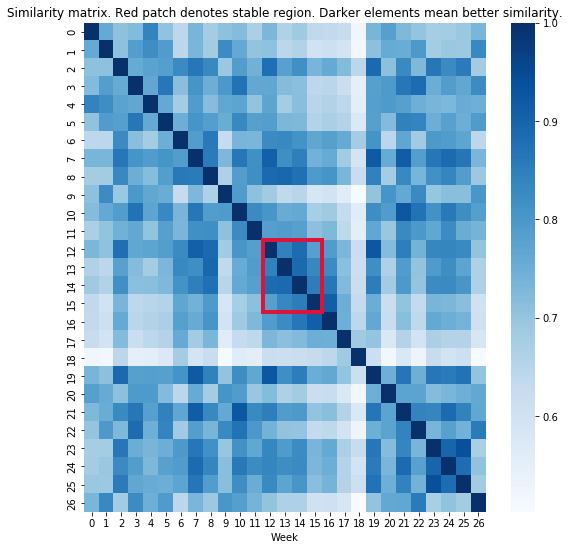

In [194]:

from matplotlib.patches import Rectangle
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances


def euclidean_similarity(values):
    d = euclidean_distances(values)
    return 1 / (1 + d)  # np.exp(-d)

def similarity_matrix(sample, uid):
    """
    Return dictionary of similarity matrix
    """

    # Reindex the DataFrame to include all dates in the range, filling missing ones
    #    date_range = pd.date_range(start=sample.index.min(), end=sample.index.max(), freq='D')
    #    sample = sample.reindex(date_range)

    # Compute the cosine similarity
    similarity = euclidean_similarity(sample.values)

    # Convert to DataFrame
    similarity_df = pd.DataFrame(similarity)

    return similarity_df

def stability_score(similarity_matrix, kernel_size=7):
    size = similarity_matrix.shape[0] - kernel_size - 1

    # Extract the similarity values of consecutive elements
    consecutive_similarity = np.diag(
        similarity_matrix, k=1
    )  # k=1 for one above the main diagonal

    stability_scores = []
    for i in range(0, size):
        kernel = consecutive_similarity[i : i + kernel_size]
        stability_scores.append(np.median(kernel))
    # Slide
    return stability_scores


def largest_stability_score(stability_score):
    if len(stability_score) == 0:
        return np.nan
    return np.array(stability_score).argmax()

def calculate_baseline_si(df, si_max, kernel_size):
    """
    Get the region with highest SI, then average
    """

    region = df.iloc[si_max : si_max + kernel_size]
    baseline = region.mean(axis=0)

    return baseline

FEATURES = ["steps:night:7ds:sum:norm","steps:morning:7ds:sum:norm","steps:afternoon:7ds:sum:norm","steps:evening:7ds:sum:norm","tst:norm:mean", "midsleep:norm:mean","heart_rate_variability_avg:mean:norm"]
kernel_size = 4
sample_behaviour = behavior_vector[behavior_vector.subject_id == uid][FEATURES]
sample_behaviour.dropna(inplace=True, subset=FEATURES)
sample_behaviour = sample_behaviour[0::7]

# print(sample.shape)
sm = similarity_matrix(sample_behaviour, uid)
si_score = stability_score(sm, kernel_size)
si_max = largest_stability_score(si_score)

# Heatmap
plt.figure(figsize=(9, 9))
ax = sns.heatmap(sm, cmap="Blues")
xlabel = 'Day' if freq == '4epochs' else 'Week'

x, y, w, h = si_max, si_max, kernel_size, kernel_size
for _ in range(2):
    ax.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor='crimson', lw=4, clip_on=False))
    x, y = y, x # exchange the roles of x and y
    w, h = h, w # exchange the roles of w and h
    
plt.xlabel(xlabel)
plt.title('Similarity matrix. Red patch denotes stable region. Darker elements mean better similarity.')

print(f'Kenrel size: {kernel_size}. Stable region {si_max} - {si_max + kernel_size}')

# Clustering

In [196]:
FEATURES = ["heart_rate_variability_avg:norm","stepsx1000:total:norm","steps:night:norm","steps:morning:norm","steps:afternoon:norm","steps:evening:norm","tst:norm","midsleep:norm"]
CORONA_PATH = "/m/cs/work/luongn1/digirhythm/data/processed/corona/vector_corona_4epochs.csv"

uid = "0xpBKXpjmT2Z"
freq = "7ds"

# Take a sample
data = pd.read_csv(CORONA_PATH , index_col=0)
data.subject_id = data.subject_id.astype('str')
s = data[data.subject_id == uid]

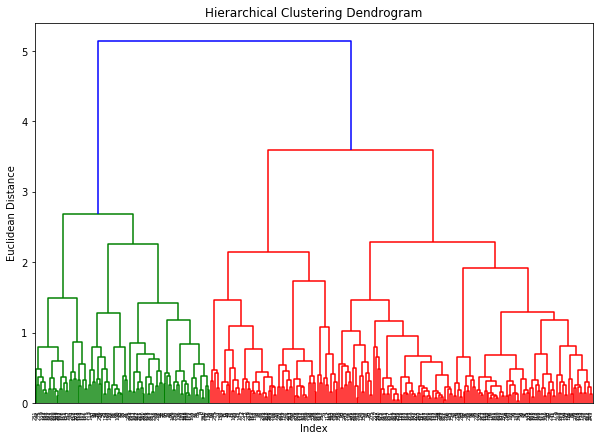

In [197]:

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

# Perform hierarchical clustering
linked = linkage(s[FEATURES], 'ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top',distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Index')
plt.ylabel('Euclidean Distance')
plt.show()


In [198]:
# Let's say we decide on 2 clusters 

from scipy.cluster.hierarchy import fcluster
k = 2
clusters = fcluster(linked, k, criterion='maxclust')

# Assign cluster labels to the original dataframe
s['cluster_label'] = clusters

# Calculating the centroids
centroids = s.groupby('cluster_label').mean()

print("Centroids of the clusters are:\n", centroids[['stepsx1000:total', 'tst', 'midsleep', 'heart_rate_variability_avg']])

Centroids of the clusters are:
                stepsx1000:total       tst  midsleep  \
cluster_label                                         
1                      9.781772  8.356087  27.76837   
2                      7.873510  7.559750  26.93345   

               heart_rate_variability_avg  
cluster_label                              
1                               56.032609  
2                               57.585000  


/share/apps/anaconda-ci/fgci-centos7-generic/software/anaconda/2020-03-tf1/f43b17a3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
